In [ ]:
%%bash
# pip install --upgrade --quiet  bitsandbytes 
pip install qwen-vl-utils[decord]==0.0.8

In [24]:
from huggingface_hub import hf_hub_download

hf_hub_download(repo_id="jwnt4/qvhighlights-val", filename="highlight_val_release_small.csv", repo_type="dataset", local_dir=".")

highlight_val_release_small.csv:   0%|          | 0.00/65.8k [00:00<?, ?B/s]

'highlight_val_release_small.csv'

In [4]:
hf_hub_download(repo_id='jwnt4/qvhighlights-val', filename="videos_small.zip", repo_type='dataset')

videos_small.zip:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

'/root/.cache/huggingface/hub/datasets--jwnt4--qvhighlights-val/snapshots/5d7957b226ee564e442c91e1a6ffe60d2635fbb7/videos_small.zip'

In [1]:
from torch import tensor
import torch
import torch.nn as nn 
import torch.functional as F
import numpy as np
import shutil
import os

In [2]:
# os.mkdir('qvhighlights-val-small')
# shutil.unpack_archive(
#     '/root/.cache/huggingface/hub/datasets--jwnt4--qvhighlights-val/snapshots/5d7957b226ee564e442c91e1a6ffe60d2635fbb7/videos_small.zip',
#     'qvhighlights-val-small', 'zip'
# )

In [3]:
prompt_template_moments = """
Instruction: You are a video assistant. Your task is to view this video and answer my question regarding the video. 
For every frame out of the {frame} frame video, give me an integer. 1 indicates the frame does not relate to the query and 2 indicates the frame relates to the query.
For example, answer 111122221111111111111111 if the relevant frames are number 4, 5, 6, and 7. Only give me {frame} amount of integers of 1 and 2 and nothing else.
Do not provide other explanations.

Question: Where does the activity "{activity}" happens in the video? 
"""

In [4]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from qwen_vl_utils import process_vision_info

# 1) Load model & processor as you already do
# bitsconfig = BitsAndBytesConfig(load_in_8bit=True)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", 
    torch_dtype=torch.bfloat16, 
    device_map="auto", 
    # quantization_config=bitsconfig
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", use_fast=True)

2025-04-24 10:08:22.830047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745489302.852213     794 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745489302.858961     794 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
!nvidia-smi

Thu Apr 24 10:08:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   74C    P0             34W /   70W |    4207MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('highlight_val_release_small.csv')
df.head(5)

,Unnamed: 0,qid,query,duration,vid,relevant_clip_ids,saliency_scores,relevant_windows
0,0,3279,A black woman wears gold sunglasses while in a...,150,8v4IP_PI8AE_60.0_210.0,"[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 4...","[[3, 4, 1], [3, 4, 3], [2, 4, 3], [3, 4, 2], [...","[[64, 92], [94, 96]]"
1,1,4326,A girl exploring a hotel room,150,ACMKgn5w2HY_60.0_210.0,"[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...","[[4, 3, 1], [4, 3, 2], [4, 3, 1], [4, 1, 3], [...","[[110, 148]]"
2,2,7299,Woman holds the camera to show off her outfit.,150,nJUP36AmrSM_510.0_660.0,"[65, 66, 67, 68, 69, 70, 71, 72, 73, 74]","[[3, 4, 2], [3, 4, 3], [3, 4, 4], [3, 4, 4], [...","[[130, 150]]"
3,3,4838,Two children are playing on the floor together...,150,u4GsXRzTqf8_210.0_360.0,"[39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5...","[[2, 1, 1], [2, 1, 1], [2, 1, 1], [2, 1, 4], [...","[[78, 122]]"
4,4,918,Man in black hat is driving a van.,150,EE0NcEec_mo_210.0_360.0,"[4, 5, 6, 8, 9, 10, 11, 18, 19, 35, 36, 39, 40...","[[4, 1, 4], [4, 1, 2], [4, 1, 2], [4, 1, 2], [...","[[8, 14], [16, 24], [36, 40], [70, 74], [78, 8..."


In [8]:
sample = df.iloc[0, :].to_dict()
sample

{'Unnamed: 0': 0,
 'qid': 3279,
 'query': 'A black woman wears gold sunglasses while in a airport lobby.',
 'duration': 150,
 'vid': '8v4IP_PI8AE_60.0_210.0',
 'relevant_clip_ids': '[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47]',
 'saliency_scores': '[[3, 4, 1], [3, 4, 3], [2, 4, 3], [3, 4, 2], [4, 4, 2], [3, 4, 1], [4, 4, 1], [3, 4, 1], [4, 4, 2], [4, 4, 2], [4, 4, 2], [4, 4, 3], [4, 4, 2], [4, 4, 2], [3, 2, 1]]',
 'relevant_windows': '[[64, 92], [94, 96]]'}

In [40]:
# 2) Prepare your messages / vision inputs
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "video",
                "video": "file:///kaggle/working/qvhighlights-val-small/8v4IP_PI8AE_60.0_210.0.mp4",
                "fps": .1,
                "max_pixels": 89*50*6,
            },
            {"type": "text", "text": "what happens in the video?"},
        ],
    }
]
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)

In [41]:
prompt_template_moments.format(frame=16, activity=sample['query'])

'\nInstruction: You are a video assistant. Your task is to view this video and answer my question regarding the video. \nFor every frame out of the 16 frame video, give me an integer. 1 indicates the frame does not relate to the query and 2 indicates the frame relates to the query.\nFor example, answer 111122221111111111111111 if the relevant frames are number 4, 5, 6, and 7. Only give me 16 amount of integers of 1 and 2 and nothing else.\nDo not provide other explanations.\n\nQuestion: Where does the activity "A black woman wears gold sunglasses while in a airport lobby." happens in the video? \n'

In [42]:
video_inputs[0].shape

torch.Size([16, 3, 112, 196])

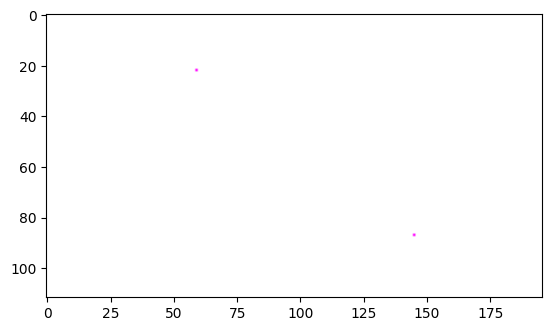

In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Example: a dummy video tensor
# video_tensor = torch.randn(16, 3, 84, 168)  # your tensor here
video_tensor = video_inputs[0].clamp(0, 1)  # ensure values are in valid range

# Convert to numpy and permute to [frames, height, width, channels]
video_np = video_tensor.permute(0, 2, 3, 1).cpu().numpy()

# Create figure and axes
fig, ax = plt.subplots()
frame = ax.imshow(video_np[0])

# Animation function
def update(i):
    frame.set_data(video_np[i])
    return frame,

# Animate
ani = animation.FuncAnimation(fig, update, frames=len(video_np), interval=100, blit=True)
HTML(ani.to_jshtml())


In [53]:
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Use input_ids as labels (the model will shift them internally)
inputs["labels"] = inputs["input_ids"]

model.eval()
with torch.inference_mode():
    outputs = model(**inputs, return_dict=True)
    logits = outputs.logits  # shape: (batch, seq_len, vocab_size)
    labels = inputs["labels"]  # shape: (batch, seq_len)

output_tokens = torch.argmax(logits, dim=-1)
output_text = processor.batch_decode(
    output_tokens, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text[0])


1服务中心 to multi AI

I







AS



 International
 travel








AYS
 walking

 from walking to woman holding


 a



, ofTravel,)



-way
 screen


 is

 screen browser
 at
 and alley
 bill






 Chang
 bowling and





)
 of with with


 and with,




 of with





:




0)
 B stores signs
 connecting adirect



channel of card to
 box products and with
 up up powdern as shows samples powderingLE cream
 and
/ay
cos's her woman samples rapper

 jacketie
 of

 in and shirt jacket

 box vacation
 bought change mirror
 video
到达:The


In [ ]:
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
).to(model.device)

generated_ids = model.generate(**inputs, max_new_tokens=256)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['The video starts with a shot of a plane taking off from Changi Airport, followed by a shot of a woman holding up a phone with a map on it. The woman then puts on a pair of glasses and looks at the camera. The video then cuts to a shot of a woman walking through an airport terminal. The woman is wearing a black jacket and has her hair pulled back. She is looking at the camera as she walks. The video then cuts to a shot of a woman sitting at a desk in an office. The woman is wearing a black shirt and has her hair pulled back. She is looking at the camera as she sits at the desk. The video then cuts to a shot of a woman standing in front of a mirror. The woman is wearing a black shirt and has her hair pulled back. She is looking at herself in the mirror as she stands there. The video then cuts to a shot of a woman sitting at a desk in an office. The woman is wearing a black shirt and has her hair pulled back. She is looking at the camera as she sits at the desk. The video then cuts to a

In [20]:
output_text

['1服务中心 to multi AI\n\nI\n\n a"\n\n\n\n\n\n car\n\n The\n\n keyboard" keyboard to playing) game with\n and player glasses bar slam Sports with, on and with and computer\n holding. on glasses woman library a with "\n and with with with book in\n professional game is the video questions video second10 the frame 0 the frame does,1 frames1, 5, 6,  11 or2 videoplay man man is a earrings" standing a room""\n\n:1']

In [4]:
from transformers import AutoProcessor, BitsAndBytesConfig, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-flan-t5-xl", use_fast=True)
quant_config = BitsAndBytesConfig(load_in_8bit=True)
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl", device_map='auto', quantization_config=quant_config)


RuntimeError: Failed to import transformers.models.auto.processing_auto because of the following error (look up to see its traceback):
partially initialized module 'torch._dynamo' has no attribute 'config' (most likely due to a circular import)

In [7]:
from PIL import Image
img = np.array(Image.open('sample-image.jpg'))

In [ ]:
labels = [
    "1 1 1 1 3 4 3 4 4 5 5 2 1 1 1 1 1 1 1"
    "1 1 1 1 1 1 1 1 1 1 1 2 5 4 4 2 4 3 1"
]
logits = []

In [38]:
text_actual = "1 1 1 1 4 2 3 4 1 1 1 1 1 1 1 1 1 1 1"
batch = [text_actual[:i*2] for i in range(3,12)]
batch

['1 1 1 ',
 '1 1 1 1 ',
 '1 1 1 1 4 ',
 '1 1 1 1 4 2 ',
 '1 1 1 1 4 2 3 ',
 '1 1 1 1 4 2 3 4 ',
 '1 1 1 1 4 2 3 4 1 ',
 '1 1 1 1 4 2 3 4 1 1 ',
 '1 1 1 1 4 2 3 4 1 1 1 ']

In [43]:
digits_token_ids = processor.tokenizer(['1', '2', '3', '4', '5'], add_special_tokens=False)['input_ids']
digits_token_ids = [digits_token_ids[i][0] for i in range(len(digits_token_ids))]
digits_token_ids

[209, 204, 220, 314, 305]

In [41]:
text_inputs = processor.tokenizer(
                batch, padding=True, return_tensors="pt"
            )
input_ids = text_inputs['input_ids']
input_ids

tensor([[209, 209, 209,   3,   1,   0,   0,   0,   0,   0,   0,   0,   0],
        [209, 209, 209, 209,   3,   1,   0,   0,   0,   0,   0,   0,   0],
        [209, 209, 209, 209, 314,   3,   1,   0,   0,   0,   0,   0,   0],
        [209, 209, 209, 209, 314, 204,   3,   1,   0,   0,   0,   0,   0],
        [209, 209, 209, 209, 314, 204, 220,   3,   1,   0,   0,   0,   0],
        [209, 209, 209, 209, 314, 204, 220, 314,   3,   1,   0,   0,   0],
        [209, 209, 209, 209, 314, 204, 220, 314, 209,   3,   1,   0,   0],
        [209, 209, 209, 209, 314, 204, 220, 314, 209, 209,   3,   1,   0],
        [209, 209, 209, 209, 314, 204, 220, 314, 209, 209, 209,   3,   1]])

In [46]:
digit_mask = ~torch.isin(input_ids, tensor(digits_token_ids))
digit_mask

tensor([[False, False, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True,
          True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True],
        [False, False, False, False, False, False, False,  True,  True,  True,
          True,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True,
          True,  True,  True],
        [False, False, False, False, False, False, False, False, False,  True,
          True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
          True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False,  True,  True]])

In [ ]:
loss = nn.CrossEntropyLoss(ignore_index=-100)


In [48]:
input_ids[digit_mask] = -100
input_ids

tensor([[ 209,  209,  209, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100],
        [ 209,  209,  209,  209, -100, -100, -100, -100, -100, -100, -100, -100,
         -100],
        [ 209,  209,  209,  209,  314, -100, -100, -100, -100, -100, -100, -100,
         -100],
        [ 209,  209,  209,  209,  314,  204, -100, -100, -100, -100, -100, -100,
         -100],
        [ 209,  209,  209,  209,  314,  204,  220, -100, -100, -100, -100, -100,
         -100],
        [ 209,  209,  209,  209,  314,  204,  220,  314, -100, -100, -100, -100,
         -100],
        [ 209,  209,  209,  209,  314,  204,  220,  314,  209, -100, -100, -100,
         -100],
        [ 209,  209,  209,  209,  314,  204,  220,  314,  209,  209, -100, -100,
         -100],
        [ 209,  209,  209,  209,  314,  204,  220,  314,  209,  209,  209, -100,
         -100]])

# Cross Entropy Loss

In [8]:
batch_size = 4
vocab_size = 32
input_size = 16
weights = torch.rand((input_size, vocab_size))
inputs = torch.rand((batch_size, input_size))
bias = torch.rand((1, vocab_size))

In [9]:
outputs = inputs @ weights + bias

In [11]:
inputs.shape, weights.shape, bias.shape, outputs.shape

(torch.Size([4, 16]),
 torch.Size([16, 32]),
 torch.Size([1, 32]),
 torch.Size([4, 32]))

In [18]:
# output cannot be guaranteed to have sum = 1
outputs.sum(dim=1)

tensor([121.7445, 125.9949, 153.5376, 106.9565])

In [23]:
softmax = nn.Softmax(dim=1)
yhat = softmax(outputs)

In [24]:
yhat.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000])

In [25]:
yhat[0]

tensor([0.0134, 0.0360, 0.0161, 0.0542, 0.0118, 0.0264, 0.0199, 0.0169, 0.0150,
        0.0517, 0.0660, 0.0251, 0.0423, 0.1195, 0.0241, 0.0482, 0.0204, 0.0201,
        0.0086, 0.0194, 0.0086, 0.1258, 0.0123, 0.0131, 0.0094, 0.0069, 0.0623,
        0.0238, 0.0212, 0.0139, 0.0371, 0.0103])

In [17]:
outputs.sum(dim=1)

tensor([121.7445, 125.9949, 153.5376, 106.9565])

In [2]:
pred_bbox = tensor([[1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0]])
test_bbox = tensor([[0,0,1,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0]])

pred_span = tensor([[0, 4], [13, 19]])
test_span = tensor([[2, 8], [12, 14]])

In [ ]:
import torch
import torch.nn as nn

# Settings
batch_size = 2
seq_len = 30
vocab_size = 255

# Simulated logits output from a model: [batch_size, seq_len, vocab_size]
logits = torch.randn(batch_size, seq_len, vocab_size, requires_grad=True)

# Simulated target labels: [batch_size, seq_len]
# Each value is an integer in the range [0, vocab_size)
targets = torch.randint(0, vocab_size, (batch_size, seq_len))

# Reshape for CrossEntropyLoss: it expects input of shape [N, C] and target [N]
logits_reshaped = logits.view(-1, vocab_size)
targets_reshaped = targets.view(-1)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Compute loss
loss = criterion(logits_reshaped, targets_reshaped)

# Backward pass to compute gradients
loss.backward()

# Check if gradients exist
print("Gradient shape (should be same as logits):", logits.grad.shape)
print("Gradients computed:", logits.grad is not None)


Gradient shape (should be same as logits): torch.Size([2, 30, 255])
Gradients computed: True


In [5]:
logits.grad.shape

torch.Size([2, 30, 255])

# GIoU implementation from Moment-detr

In [3]:
def print_vars(var_dict: dict):
    for k, v in var_dict.items():
        print(k, v, sep='\n', end='\n\n')

In [10]:
def temporal_iou(spans1, spans2):
    """
    Args:
        spans1: (N, 2) torch.Tensor, each row defines a span [st, ed]
        spans2: (M, 2) torch.Tensor, ...

    Returns:
        iou: (N, M) torch.Tensor
        union: (N, M) torch.Tensor
    >>> test_spans1 = torch.Tensor([[0, 0.2], [0.5, 1.0]])
    >>> test_spans2 = torch.Tensor([[0, 0.3], [0., 1.0]])
    >>> temporal_iou(test_spans1, test_spans2)
    (tensor([[0.6667, 0.2000],
         [0.0000, 0.5000]]),
     tensor([[0.3000, 1.0000],
             [0.8000, 1.0000]]))
    """
    areas1 = spans1[:, 1] - spans1[:, 0]  # (N, )
    areas2 = spans2[:, 1] - spans2[:, 0]  # (M, )
    left = torch.max(spans1[:, None, 0], spans2[:, 0])  # (N, M)
    right = torch.min(spans1[:, None, 1], spans2[:, 1])  # (N, M)
    inter = (right - left).clamp(min=0)  # (N, M)
    union = areas1[:, None] + areas2 - inter  # (N, M)
    iou = inter / union
    # print_vars(dict(spans1=spans1, spans2=spans2,
    #     areas1=areas1, areas2=areas2, left=left, right=right, inter=inter, union=union, iou=iou,
    # ))
    # print_vars(dict(
    #     sorcery1=spans1[:, None, 0], sorcery2=spans2[:, 0],
    #     sorcery3=spans1[:, None, 1], sorcery4=spans2[:, 1]
    # ))
    return iou, union


def generalized_temporal_iou(spans1, spans2):
    """
    Generalized IoU from https://giou.stanford.edu/
    Also reference to DETR implementation of generalized_box_iou
    https://github.com/facebookresearch/detr/blob/master/util/box_ops.py#L40

    Args:
        spans1: (N, 2) torch.Tensor, each row defines a span in xx format [st, ed]
        spans2: (M, 2) torch.Tensor, ...

    Returns:
        giou: (N, M) torch.Tensor

    >>> test_spans1 = torch.Tensor([[0, 0.2], [0.5, 1.0]])
    >>> test_spans2 = torch.Tensor([[0, 0.3], [0., 1.0]])
    >>> generalized_temporal_iou(test_spans1, test_spans2)
    tensor([[ 0.6667,  0.2000],
        [-0.2000,  0.5000]])
    """
    spans1 = spans1.float()
    spans2 = spans2.float()
    assert (spans1[:, 1] >= spans1[:, 0]).all()
    assert (spans2[:, 1] >= spans2[:, 0]).all()
    iou, union = temporal_iou(spans1, spans2)

    left = torch.min(spans1[:, None, 0], spans2[:, 0])  # (N, M)
    right = torch.max(spans1[:, None, 1], spans2[:, 1])  # (N, M)
    enclosing_area = (right - left).clamp(min=0)  # (N, M)
    print(f"{enclosing_area=}")
    return iou - (enclosing_area - union) / enclosing_area


In [11]:
pred_bbox = tensor([[1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0]])
test_bbox = tensor([[0,0,1,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0]])

In [12]:
pred_span = tensor([[0, 4], [13, 19]], dtype=torch.float32) / 20
test_span = tensor([[2, 8], [12, 14]], dtype=torch.float32) / 20
pred_span.requires_grad_()

tensor([[0.0000, 0.2000],
        [0.6500, 0.9500]], requires_grad=True)

In [14]:
import torch

# call your differentiable IoU/GIoU fn
giou = generalized_temporal_iou(pred_span, test_span)  # shape (1,1)
loss = (1 - torch.diag(giou)).mean()
loss.backward()

print(pred_span.grad)  # if this is all zeros, gradient died in the loop


enclosing_area=tensor([[0.4000, 0.7000],
        [0.8500, 0.3500]], grad_fn=<ClampBackward1>)
tensor([[-0.3125, -1.2500],
        [ 1.4286,  0.2041]])


In [69]:
left = torch.max(
    tensor([[ 0],
            [13]]),
    tensor([2, 12])
)

In [68]:
right = torch.min(
    tensor([[ 4],
            [19]]),
    tensor([8, 14])
)

In [73]:
right, left, (right-left)

(tensor([[ 4,  4],
         [ 8, 14]]),
 tensor([[ 2, 12],
         [13, 13]]),
 tensor([[ 2, -8],
         [-5,  1]]))

In [66]:
temporal_iou(
    pred_span, test_span
)

spans1
tensor([[ 0,  4],
        [13, 19]])

spans2
tensor([[ 2,  8],
        [12, 14]])

areas1
tensor([4, 6])

areas2
tensor([6, 2])

left
tensor([[ 2, 12],
        [13, 13]])

right
tensor([[ 4,  4],
        [ 8, 14]])

inter
tensor([[2, 0],
        [0, 1]])

union
tensor([[ 8,  6],
        [12,  7]])

iou
tensor([[0.2500, 0.0000],
        [0.0000, 0.1429]])

sorcery1
tensor([[ 0],
        [13]])

sorcery2
tensor([ 2, 12])

sorcery3
tensor([[ 4],
        [19]])

sorcery4
tensor([ 8, 14])



(tensor([[0.2500, 0.0000],
         [0.0000, 0.1429]]),
 tensor([[ 8,  6],
         [12,  7]]))

In [75]:
torch.diag(tensor([[0.2500, 0.0000],
         [0.0000, 0.1429]])).mean()

tensor(0.1964)

In [58]:
giou_span = generalized_temporal_iou(pred_span, test_span)
giou_span

areas1
tensor([4., 6.])

areas2
tensor([6., 2.])

left
tensor([[ 2., 12.],
        [13., 13.]])

right
tensor([[ 4.,  4.],
        [ 8., 14.]])

inter
tensor([[2., 0.],
        [0., 1.]])

union
tensor([[ 8.,  6.],
        [12.,  7.]])

iou
tensor([[0.2500, 0.0000],
        [0.0000, 0.1429]])

sorcery1
tensor([[ 0.],
        [13.]])

sorcery2
tensor([ 2., 12.])

enclosing_area=tensor([[ 8., 14.],
        [17.,  7.]])


tensor([[ 0.2500, -0.5714],
        [-0.2941,  0.1429]])

In [20]:
giou_loss_span = 1 - torch.diag(giou_span)
giou_loss_span, giou_loss_span.mean()

(tensor([0.7500, 0.8571]), tensor(0.8036))

# BBox Implementation

In [21]:
def temporal_iou_bbox(masks1, masks2):
    """
    Args:
        masks1: (N, L) torch.Tensor with binary values (0 or 1)
        masks2: (M, L) torch.Tensor with binary values (0 or 1)

    Returns:
        iou: (N, M) torch.Tensor
        union: (N, M) torch.Tensor
    """
    masks1 = masks1.float()
    masks2 = masks2.float()

    # (N, M, L) shape after broadcasting
    intersection = (masks1[:, None, :] * masks2[None, :, :]).sum(dim=2)
    area1 = masks1.sum(dim=1)  # (N,)
    area2 = masks2.sum(dim=1)  # (M,)
    union = area1[:, None] + area2[None, :] - intersection  # (N, M)

    iou = intersection / union.clamp(min=1e-6)
    return iou, union


def generalized_temporal_iou_bbox(masks1, masks2):
    """
    Generalized IoU for 1D segmentation masks.

    Args:
        masks1: (N, L) torch.Tensor with binary values (0 or 1)
        masks2: (M, L) torch.Tensor with binary values (0 or 1)

    Returns:
        giou: (N, M) torch.Tensor
    """
    masks1 = masks1.float()
    masks2 = masks2.float()

    iou, union = temporal_iou_bbox(masks1, masks2)

    # Enclosing box: union of supports (non-zero positions)
    # Find leftmost and rightmost 1s in either mask
    N, L = masks1.shape
    M = masks2.shape[0]

    enclosing_area = torch.zeros((N, M), dtype=torch.float32)

    for i in range(N):
        idx1 = torch.where(masks1[i] > 0)[0]
        if len(idx1) == 0:
            continue
        min1, max1 = idx1[0].item(), idx1[-1].item()
        for j in range(M):
            idx2 = torch.where(masks2[j] > 0)[0]
            if len(idx2) == 0:
                continue
            min2, max2 = idx2[0].item(), idx2[-1].item()
            left = min(min1, min2)
            right = max(max1, max2)
            enclosing_area[i, j] = right - left + 1  # +1 for inclusive span

    giou = iou - (enclosing_area - union) / enclosing_area.clamp(min=1e-6)
    return giou

In [93]:
import torch

# toy continuous “mask” (not hard 0/1) so gradients can flow
pred = torch.tensor([[0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0]], requires_grad=True, dtype=torch.float32)
# treat test as fixed float mask
test = torch.tensor([[0,0,0,1,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0]], dtype=torch.float32)

# call your differentiable IoU/GIoU fn
giou = generalized_temporal_iou_bbox(pred, test)  # shape (1,1)
loss = 1 - giou[0,0]
loss.backward()

print(pred.grad)  # if this is all zeros, gradient died in the loop


tensor([[-0.0506, -0.0506, -0.0506, -0.0833, -0.0833, -0.0833, -0.0833, -0.0833,
         -0.0833, -0.0506, -0.0506, -0.0506, -0.0506, -0.0833, -0.0833, -0.0506,
         -0.0506, -0.0506, -0.0506, -0.0506, -0.0506]])


In [95]:
1- generalized_temporal_iou_bbox(pred, test)

tensor([[0.8929]], grad_fn=<RsubBackward1>)

In [22]:
temporal_iou_bbox(pred_bbox, test_bbox)

(tensor([[0.2000]]), tensor([[15.]]))

In [26]:
generalized_temporal_iou_bbox(pred_bbox, test_bbox)

tensor([[-0.0105]])

In [13]:
1 - torch.diag(generalized_temporal_iou_bbox(pred_bbox, test_bbox))

tensor([1.0105])

In [ ]:


intersection = torch.sum(pred_bbox & test_bbox)
area_pred = torch.sum(pred_bbox)
area_test = torch.sum(test_bbox)
union = area_pred + area_test - intersection


In [ ]:
import numpy as np

def giou_1d(pred, test):
    pred = np.array(pred)
    test = np.array(test)

    intersection = np.sum(pred & test)
    area_pred = np.sum(pred)
    area_test = np.sum(test)
    union = area_pred + area_test - intersection

    if union == 0:
        return 1.0  # Special case: empty pred and test

    active_indices = np.where((pred + test) > 0)[0]
    x1_c = active_indices[0]
    x2_c = active_indices[-1]
    area_c = x2_c - x1_c + 1

    iou = intersection / union
    giou = iou - (area_c - union) / area_c

    return giou

# Example
pred_bbox = [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0]
test_bbox = [0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1]

print(giou_1d(pred_bbox, test_bbox))


In [ ]:
span_cxw_to_xx()

In [ ]:
preds = torch.zeros((5, 40))
tests = torch.zeros((5, 40))

tests[0][1:8] = 1
tests[0][]

In [ ]:
generalized_temporal_iou(
    tensor([1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
    tensor([0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0])
)